# Assignment 1 - Patient classification

In this Jupyter notebook, we are going to analyze data from the medical field, related to a number of patients and the diseases they have been diagnosed with, and we are going to train four classifiers (`RandomForest`, `ExtraTrees`, `GradientBoosted Trees` and `SVM`) in order to predict a patient's diagnostic, based on the collected attributes.

## Dependencies

In order to run this notebook, some packages need to be installed, with the commands provided below:

In [44]:
%pip install xgboost


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /usr/local/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Imports

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

from functools import partial, reduce
from typing import TypeVar, List, Tuple, Optional, Callable

import warnings

## Helpers

In this section, we will define a series of helper constants, type synonyms and functions for later use.

**SPOILER ALERT**: They are inspired from the way one would write code in Haskell, as is the programming style used throughout this notebook :)

In [46]:
# TYPES
T = TypeVar('T')

String = str
Bool = bool

# CONSTANTS
FILE = 'date_tema_1_iaut_2024.csv'

# FUNCTIONS
def compose(*funcs):
    return lambda x: reduce(lambda acc, f: f(acc), reversed(funcs), x)

def init(l : List[T]) -> T:
    return l[:-1]

## Reading the data

In [47]:
def get_data(file):
    return pd.read_csv(file, decimal = ',')

df = get_data(FILE)
df

,Transportation,Regular_fiber_diet,Diagnostic_in_family_history,High_calorie_diet,Sedentary_hours_daily,Age,Alcohol,Est_avg_calorie_intake,Main_meals_daily,Snacks,Height,Smoker,Water_daily,Calorie_monitoring,Weight,Physical_activity_level,Technology_time_use,Gender,Diagnostic
0,Public_Transportation,2.0,yes,no,3.73,21.000000,no,2474,3.0,Sometimes,1.62,no,2.000000,no,64.000000,0.000000,1,Female,D1
1,Public_Transportation,3.0,yes,no,2.92,21.000000,Sometimes,2429,3.0,Sometimes,1.52,yes,3.000000,yes,56.000000,3.000000,0,Female,D1
2,Public_Transportation,2.0,yes,no,3.85,23.000000,Frequently,2656,3.0,Sometimes,1.80,no,2.000000,no,77.000000,2.000000,1,Male,D1
3,Walking,3.0,no,no,3.01,27.000000,Frequently,2260,3.0,Sometimes,1.80,no,2.000000,no,-1.000000,2.000000,0,Male,D2
4,Public_Transportation,2.0,no,no,2.73,22.000000,Sometimes,1895,1.0,Sometimes,1.78,no,2.000000,no,89.800000,0.000000,0,Male,D3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916,Public_Transportation,3.0,yes,yes,3.08,20.976842,Sometimes,2744,3.0,Sometimes,1.71,no,1.728139,no,131.408528,1.676269,1,Female,D6
1917,Public_Transportation,3.0,yes,yes,3.00,21.982942,Sometimes,2977,3.0,Sometimes,1.75,no,2.005130,no,133.742943,1.341390,1,Female,D6
1918,Public_Transportation,3.0,yes,yes,3.26,22.524036,Sometimes,2422,3.0,Sometimes,1.75,no,2.054193,no,133.689352,1.414209,1,Female,D6
1919,Public_Transportation,3.0,yes,yes,3.61,24.361936,Sometimes,2372,3.0,Sometimes,1.74,no,2.852339,no,133.346641,1.139107,1,Female,D6


### Data type analysis

In [48]:
def check_datatypes(df : pd.DataFrame) -> pd.DataFrame:
    types = pd.DataFrame({col : df[col].dtype for col in df.columns}, index = ['Datatype']).T
    return types

check_datatypes(df)

,Datatype
Transportation,object
Regular_fiber_diet,float64
Diagnostic_in_family_history,object
High_calorie_diet,object
Sedentary_hours_daily,float64
Age,float64
Alcohol,object
Est_avg_calorie_intake,int64
Main_meals_daily,float64
Snacks,object


## Cleaning the dataset

Because the original dataset contains, in the numerical attributes' columns, outliers whose values are orders of magnitude higher than those of the standard values (e.g. 1683 and 1915 in the "Height" column), they need to be filtered out of the dataset. We will replace those values with NaN.

In [49]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Filter the 'Age' attribute
        df['Age'].iloc[df['Age'] > 150] = pd.NA
        df['Age'].iloc[df['Age'] < 0] = pd.NA

        # Filter the 'Weight' attribute
        df['Weight'].iloc[df['Weight'] > 350] = pd.NA
        df['Weight'].iloc[df['Weight'] < 0] = pd.NA

        # Filter the 'Height' attribute
        df['Height'].iloc[df['Height'] > 3] = pd.NA
        df['Height'].iloc[df['Height'] < 0] = pd.NA

        # Filter the 'Regular_fiber_diet' attribute
        df['Regular_fiber_diet'].iloc[df['Regular_fiber_diet'] > 10] = pd.NA

        # Filter the 'Technology_time_use' attribute
        df['Technology_time_use'].iloc[df['Technology_time_use'] > 24] = pd.NA

        # Filter the 'Sedentary_hours_daily' attribute
        df['Sedentary_hours_daily'].iloc[df['Sedentary_hours_daily'] > 24] = pd.NA
        return df

df = preprocess(df)

## Viewing the data

### Checking out the class distribution

In [50]:
def med_abs_dev(series : pd.Series) -> float:
    devs = series - series.mean()
    return devs.abs().median()

def mean_abs_dev(series : pd.Series) -> float:
    devs = series - series.mean()
    return devs.abs().mean()

def IQR(series : pd.Series) -> float:
    return series.quantile(0.75) - series.quantile(0.25)

def check_distribution(df : pd.DataFrame, attr : String, type : String, analysis : Optional[String], print_barplot : Bool) -> Optional[pd.Series]:
    match type:
        case 'categorical':
            if print_barplot:
                sns.countplot(x = attr, data = df)
            
            distribution = df[attr].value_counts()
            match analysis:
                case 'count':
                    return distribution
                case 'statistics':
                    return distribution.describe().loc[['mean', 'std', 'min', 'max', '25%', '50%', '75%']]
                case _:
                    print('Invalid attribute type')
                    return None
        case 'ordinal':
            if print_barplot:
                sns.countplot(x = attr, data = df)
            
            distribution = df[attr].value_counts()
            match analysis:
                case 'count':
                    return distribution
                case 'statistics':
                    return distribution.describe().loc[['min', 'max', '25%', '50%', '75%']]
                case _:
                    print('Invalid attribute type')
                    return None
        case 'numerical':
            distribution = pd.to_numeric(df[attr], errors = 'coerce').dropna()
            stats = distribution.describe().loc[['mean', 'std', 'min', 'max', '25%', '50%', '75%']]
            new_stats = pd.Series({'mean absolute deviation': mean_abs_dev(distribution), 'median absolute deviation': med_abs_dev(distribution), 'IQR': IQR(distribution)})
            stats = pd.concat([stats, new_stats])
            return stats
        case _:
            print('Invalid attribute type')
            return None

mean    274.428571
std      25.244518
min     246.000000
max     320.000000
25%     260.000000
50%     269.000000
75%     283.000000
Name: count, dtype: float64


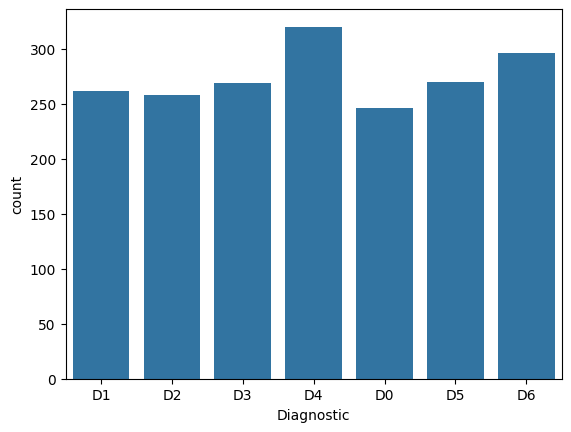

In [51]:
check_class_distribution = partial(check_distribution, attr = 'Diagnostic', type = 'categorical', print_barplot = True)
print(check_class_distribution(df, analysis = 'statistics'))

As we can see, the class distribution is very balanced: we have slightly more cases of diagnostic D4, but overall the distribution resembles very well a uniform distribution.

### Attribute analysis

In [52]:
def analyze_attributes(df : pd.DataFrame, attributes : List[String], types : List[String], analysis : String):
    for attr, type in zip(attributes, types):
        print(f'Attribute: {attr}')
        stats = check_distribution(df, attr, type, analysis = analysis, print_barplot = False)
        print(stats)
        print('\n')

In [53]:
stats = check_distribution(df, 'Regular_fiber_diet', 'numerical', 'count', print_barplot = True)
print(stats)

mean                         2.420377
std                          0.533208
min                          1.000000
max                          3.000000
25%                          2.000000
50%                          2.386464
75%                          3.000000
mean absolute deviation      0.478151
median absolute deviation    0.420377
IQR                          1.000000
dtype: float64


In [54]:
def extract_type(df : pd.DataFrame, attr : String) -> String:
    match attr:
        case 'Technology_time_use':
            return 'categorical'
        case 'Main_meals_daily':
            return 'ordinal'
        case _:
            if isinstance(df[attr].iloc[0], String):
                return 'categorical'
            else:
                return 'numerical'

def plot_attribute_statistics(df : pd.DataFrame, attributes : List[String]):
    attr_types = list(map(partial(extract_type, df), attributes))
    analyze_attributes(df, attributes, attr_types, 'statistics')

def plot_attribute_counts(df : pd.DataFrame, attributes : List[String]):
    attr_types = list(map(partial(extract_type, df), attributes))
    analyze_attributes(df, attributes, attr_types, 'count')

In [55]:
plot_attribute_counts(df, init(list(df.columns)))

Attribute: Transportation
Transportation
Public_Transportation    1427
Automobile                423
Walking                    53
Motorbike                  11
Bike                        7
Name: count, dtype: int64


Attribute: Regular_fiber_diet
mean                         2.420377
std                          0.533208
min                          1.000000
max                          3.000000
25%                          2.000000
50%                          2.386464
75%                          3.000000
mean absolute deviation      0.478151
median absolute deviation    0.420377
IQR                          1.000000
dtype: float64


Attribute: Diagnostic_in_family_history
Diagnostic_in_family_history
yes    1573
no      348
Name: count, dtype: int64


Attribute: High_calorie_diet
High_calorie_diet
yes    1697
no      224
Name: count, dtype: int64


Attribute: Sedentary_hours_daily
mean                         3.197276
std                          0.575756
min                      

Transportation
Public_Transportation    1427
Automobile                423
Walking                    53
Motorbike                  11
Bike                        7
Name: count, dtype: int64

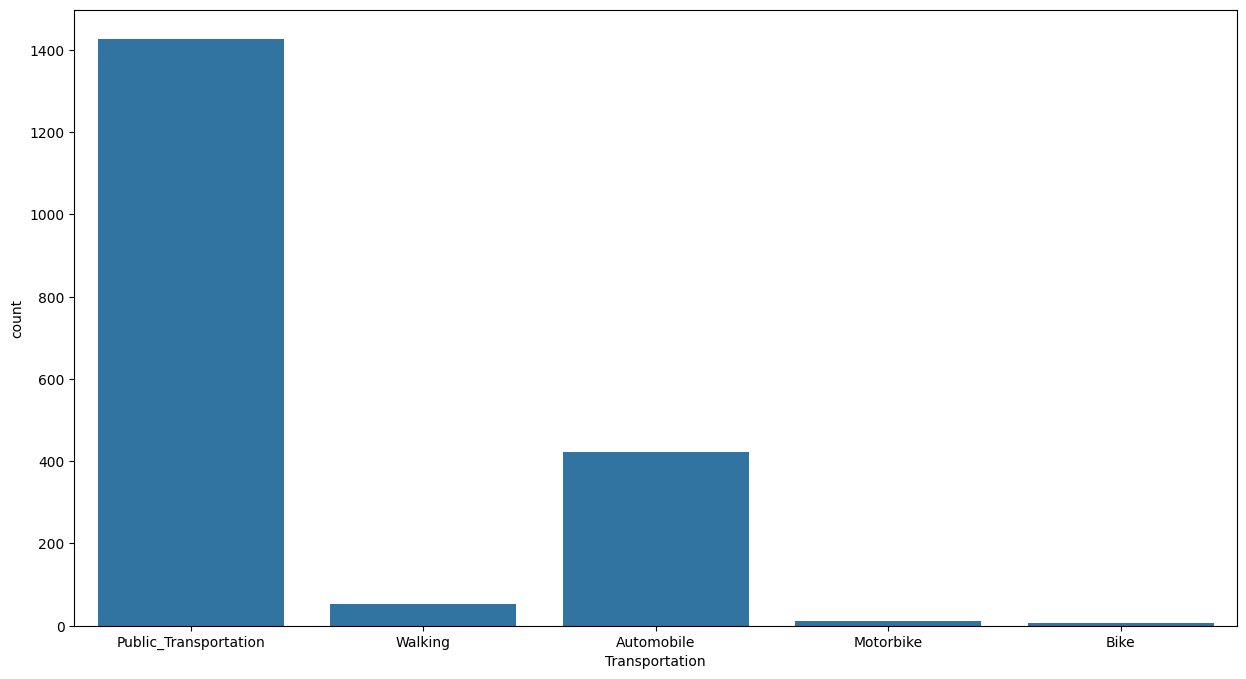

In [56]:
plt.figure(figsize = (15, 8))
check_distribution(df, 'Transportation', 'categorical', 'count', print_barplot = True)

Alcohol
Sometimes     1269
no             585
Frequently      66
Always           1
Name: count, dtype: int64

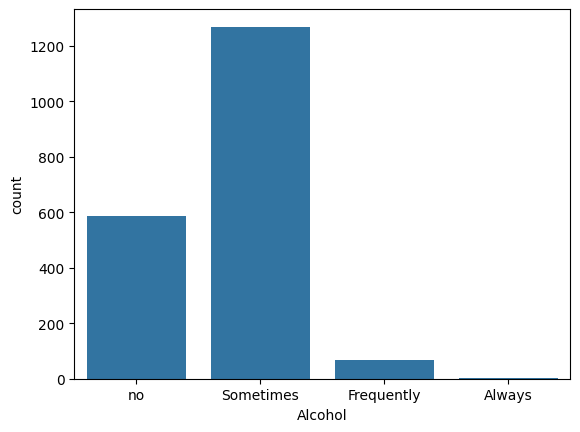

In [57]:
check_distribution(df, 'Alcohol', 'categorical', 'count', print_barplot = True)

Snacks
Sometimes     1609
Frequently     221
Always          48
no              43
Name: count, dtype: int64

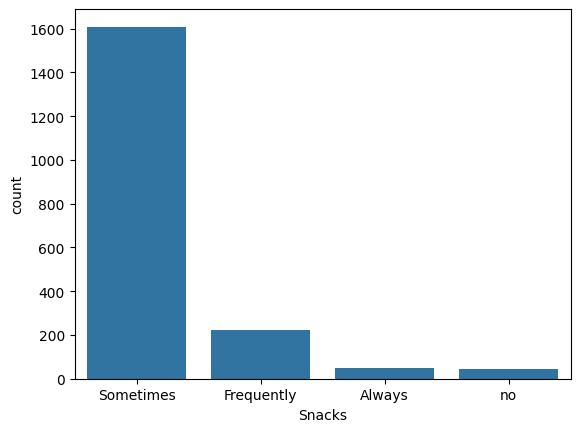

In [58]:
check_distribution(df, 'Snacks', 'categorical', 'count', print_barplot = True)

Smoker
no     1881
yes      40
Name: count, dtype: int64

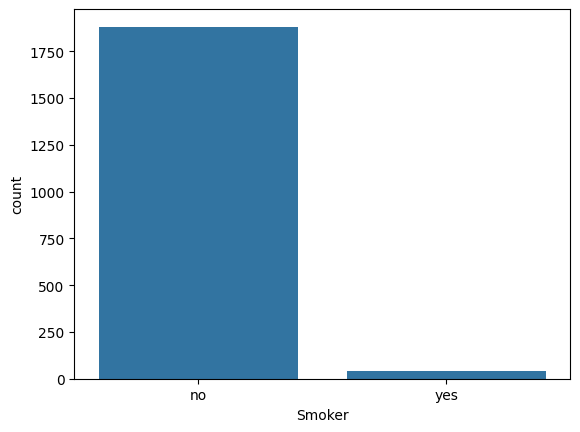

In [59]:
check_distribution(df, 'Smoker', 'categorical', 'count', print_barplot = True)

High_calorie_diet
yes    1697
no      224
Name: count, dtype: int64

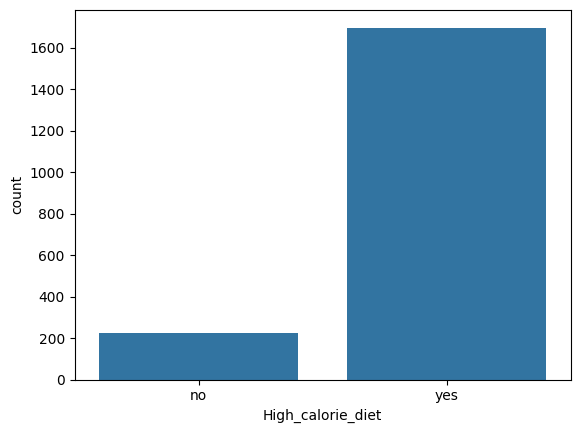

In [60]:
check_distribution(df, 'High_calorie_diet', 'categorical', 'count', print_barplot = True)

Diagnostic_in_family_history
yes    1573
no      348
Name: count, dtype: int64

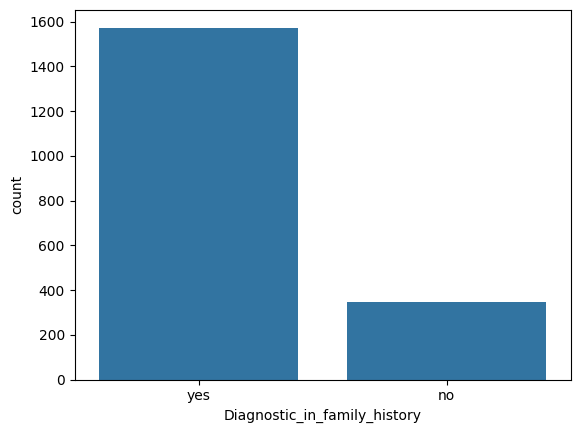

In [61]:
check_distribution(df, 'Diagnostic_in_family_history', 'categorical', 'count', print_barplot = True)

Calorie_monitoring
no     1838
yes      83
Name: count, dtype: int64

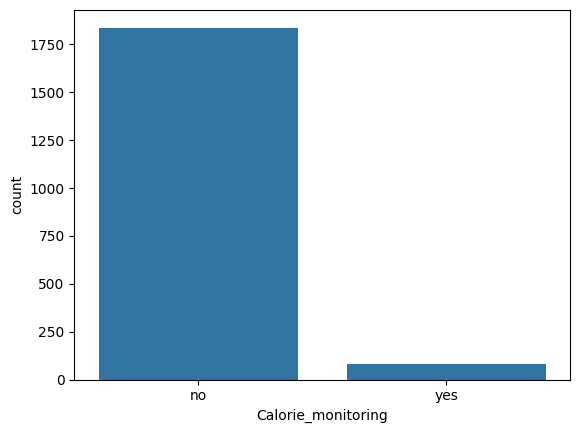

In [62]:
check_distribution(df, 'Calorie_monitoring', 'categorical', 'count', print_barplot = True)

Gender
Male      977
Female    944
Name: count, dtype: int64

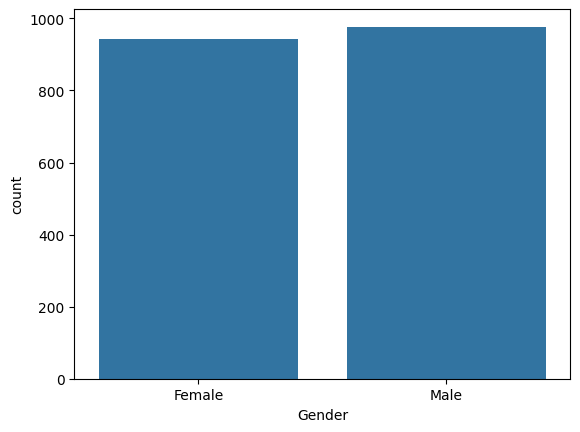

In [63]:
check_distribution(df, 'Gender', 'categorical', 'count', print_barplot = True)

Technology_time_use
0.0    865
1.0    831
2.0    224
Name: count, dtype: int64

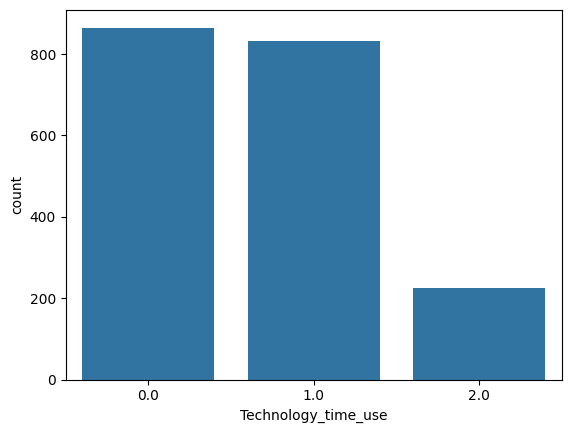

In [64]:
check_distribution(df, 'Technology_time_use', 'categorical', 'count', print_barplot = True)

## Covariance analysis

In this section we are going to analyse which attribute(s) have the most impact in determining a patient's diagnostic, and see how the attributes are correlated to each other.

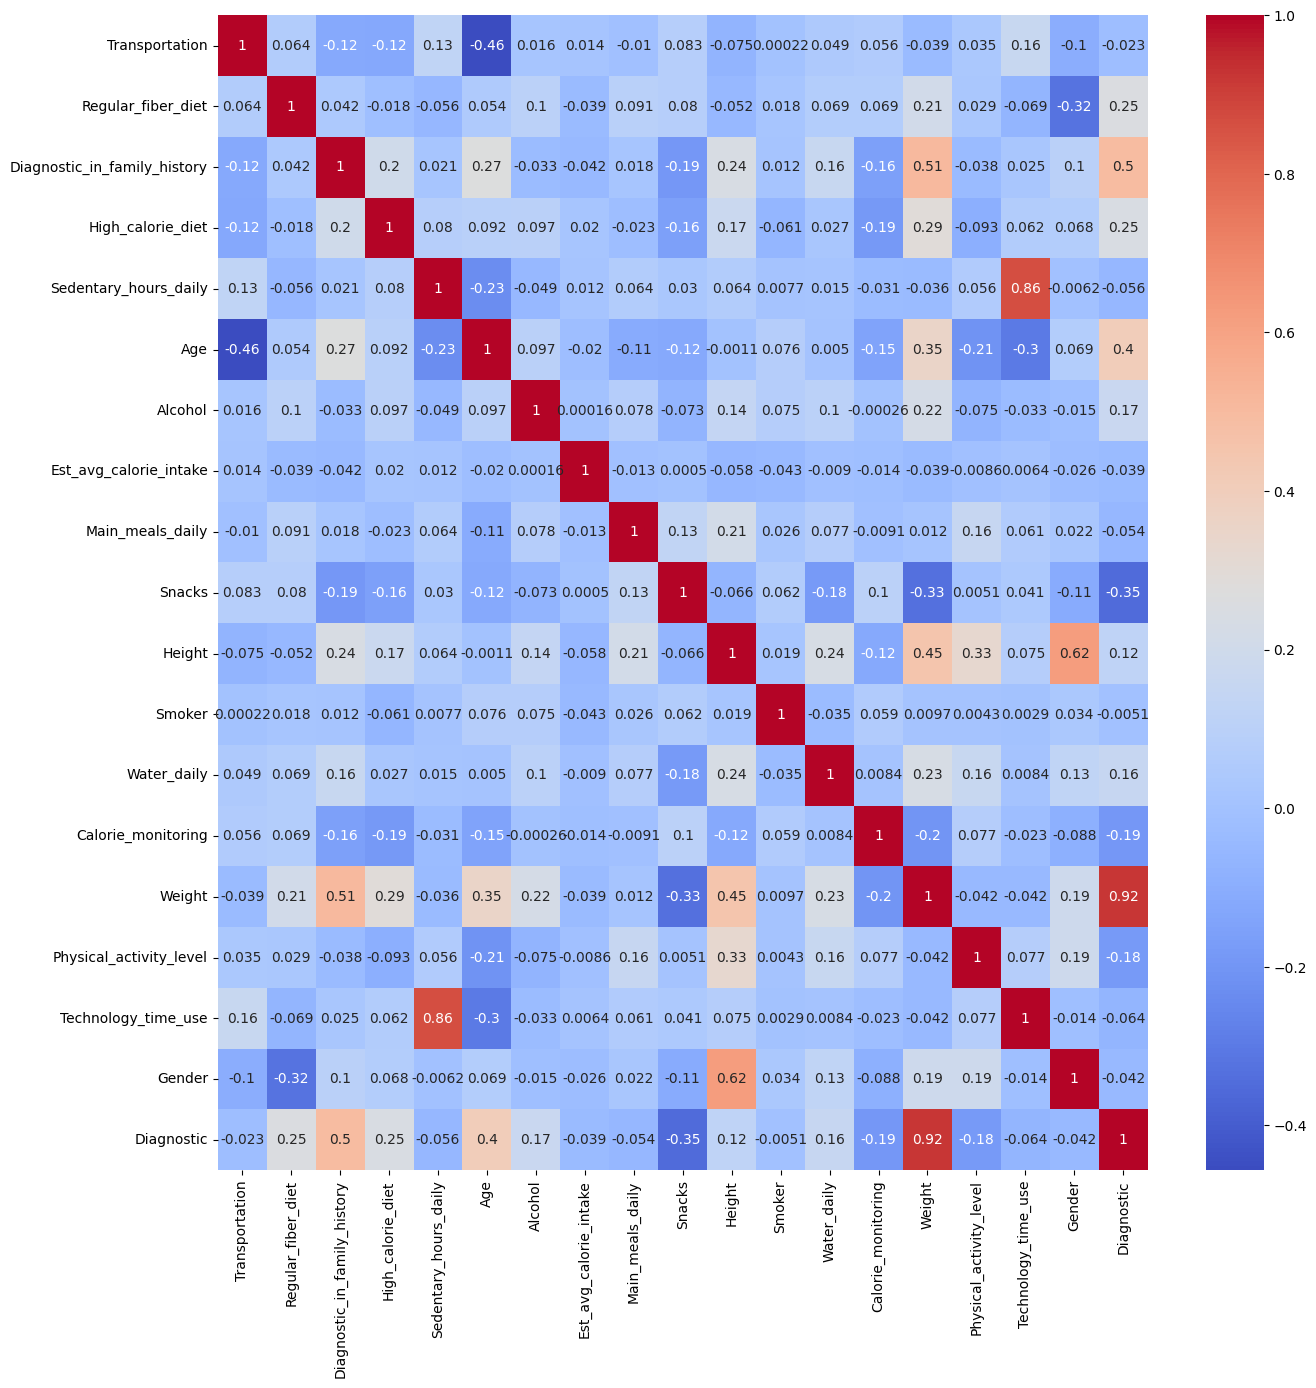

In [65]:
def convert_to_numbers(df : pd.DataFrame) -> pd.DataFrame:
    df['Transportation'] = df['Transportation'].replace({'Automobile': 0, 'Public_Transportation': 1, 'Motorbike': 2, 'Bike': 3, 'Walking': 4})
    df['Alcohol'] = df['Alcohol'].replace({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
    df['Snacks'] = df['Snacks'].replace({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
    df['Smoker'] = df['Smoker'].replace({'no': 0, 'yes': 1})
    df['High_calorie_diet'] = df['High_calorie_diet'].replace({'no': 0, 'yes': 1})
    df['Diagnostic_in_family_history'] = df['Diagnostic_in_family_history'].replace({'no': 0, 'yes': 1})
    df['Calorie_monitoring'] = df['Calorie_monitoring'].replace({'no': 0, 'yes': 1})
    df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1})
    df['Diagnostic'] = df['Diagnostic'].replace({'D0': 0, 'D1': 1, 'D2': 2, 'D3': 3, 'D4': 4, 'D5': 5, 'D6': 6})
    return df

def compute_correlation_matrix(df : pd.DataFrame) -> pd.DataFrame:
    df = convert_to_numbers(df)
    return df.corr(method = 'spearman') # Spearman instead of Pearson because we don't know whether the correlations are all linear

def plot_correlation_matrix(df : pd.DataFrame):
    corr_matrix = compute_correlation_matrix(df)
    plt.figure(figsize = (15, 15))
    sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')
    plt.show()

plot_correlation_matrix(df)

From the covariance analysis, we can extract multiple conclusions, several of which being:
- the attributes with the highest correlation with the diagnostic were the weight and the presence of a diagnostic in the family history of the patient, with correlation coefficients of $0.92$ and $0.5$, respectively
- the age of the patient had a quite significant outcome in predicting the patient's disease, with a correlation coefficient of $0.4$
- the time dedicated to technology use was very strongly correlated with the number of sedentary hours a day, with a coefficient of $0.86$ (positive correlation, i.e. the more time someone uses technology, the more hours they are likely to not move around)
- the presence of a diagnostic in the family history was relatively strongly correlated with the weight of the patient, with a score of $0.51$ (positive correlation, i.e. if one has a history of diseases, they are more likely to be overweight)
- the height and the weight of a patient were correlated with a coefficient of $0.45$ (positive correlation). This might be explained intuitively by the fact that men tend to have both bigger height and weight than women

## Data normalization

### Converting all numerical attributes to the same order of magnitude

The data analysis done so far has shown us that the estimated average calorie intake has values which are in the thousands (more specifically, between $1500$ and $3000$). Because this may influence negatively the performances of the classifiers that we will train, we will bring the values into the range $[1, 3]$ by dividing every value in the said column by $1000$. Since this transformation just remaps the values of the attribute to a new range, without changing the standard deviation, the distribution of the data will not be changed.

In [66]:
def normalize_data(df : pd.DataFrame) -> pd.DataFrame:
    df['Est_avg_calorie_intake'] = df['Est_avg_calorie_intake'].apply(lambda x: x / 1000)
    return df

In [67]:
df = compose(normalize_data, convert_to_numbers, preprocess, get_data)(FILE)
df

,Transportation,Regular_fiber_diet,Diagnostic_in_family_history,High_calorie_diet,Sedentary_hours_daily,Age,Alcohol,Est_avg_calorie_intake,Main_meals_daily,Snacks,Height,Smoker,Water_daily,Calorie_monitoring,Weight,Physical_activity_level,Technology_time_use,Gender,Diagnostic
0,1,2.0,1,0,3.73,21.000000,0,2.474,3.0,1,1.62,0,2.000000,0,64.000000,0.000000,1.0,0,1
1,1,3.0,1,0,2.92,21.000000,1,2.429,3.0,1,1.52,1,3.000000,1,56.000000,3.000000,0.0,0,1
2,1,2.0,1,0,3.85,23.000000,2,2.656,3.0,1,1.80,0,2.000000,0,77.000000,2.000000,1.0,1,1
3,4,3.0,0,0,3.01,27.000000,2,2.260,3.0,1,1.80,0,2.000000,0,NaN,2.000000,0.0,1,2
4,1,2.0,0,0,2.73,22.000000,1,1.895,1.0,1,1.78,0,2.000000,0,89.800000,0.000000,0.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916,1,3.0,1,1,3.08,20.976842,1,2.744,3.0,1,1.71,0,1.728139,0,131.408528,1.676269,1.0,0,6
1917,1,3.0,1,1,3.00,21.982942,1,2.977,3.0,1,1.75,0,2.005130,0,133.742943,1.341390,1.0,0,6
1918,1,3.0,1,1,3.26,22.524036,1,2.422,3.0,1,1.75,0,2.054193,0,133.689352,1.414209,1.0,0,6
1919,1,3.0,1,1,3.61,24.361936,1,2.372,3.0,1,1.74,0,2.852339,0,133.346641,1.139107,1.0,0,6


### Taking care of NaN values

So far, we have seen that our dataset contains some missing values in the "Weight" column, values which were marked as being $-1$. We can leave them untouched, but, in order to improve the predictive power of the classifiers, we will try to estimate them from the values in the other colums using an `IterativeImputer`. We will do so for the outliers we have identified (and replaced with NaN) previously.

In [68]:
def impute_data(df : pd.DataFrame) -> pd.DataFrame:
    imputer = IterativeImputer(max_iter = 20, initial_strategy = 'mean', random_state = 42)
    df.iloc[:, :-1] = imputer.fit_transform(df.iloc[:, :-1])
    return df

In [69]:
df = impute_data(df)
df

,Transportation,Regular_fiber_diet,Diagnostic_in_family_history,High_calorie_diet,Sedentary_hours_daily,Age,Alcohol,Est_avg_calorie_intake,Main_meals_daily,Snacks,Height,Smoker,Water_daily,Calorie_monitoring,Weight,Physical_activity_level,Technology_time_use,Gender,Diagnostic
0,1,2.0,1,0,3.73,21.000000,0,2.474,3.0,1,1.62,0,2.000000,0,64.000000,0.000000,1.0,0,1
1,1,3.0,1,0,2.92,21.000000,1,2.429,3.0,1,1.52,1,3.000000,1,56.000000,3.000000,0.0,0,1
2,1,2.0,1,0,3.85,23.000000,2,2.656,3.0,1,1.80,0,2.000000,0,77.000000,2.000000,1.0,1,1
3,4,3.0,0,0,3.01,27.000000,2,2.260,3.0,1,1.80,0,2.000000,0,93.379922,2.000000,0.0,1,2
4,1,2.0,0,0,2.73,22.000000,1,1.895,1.0,1,1.78,0,2.000000,0,89.800000,0.000000,0.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916,1,3.0,1,1,3.08,20.976842,1,2.744,3.0,1,1.71,0,1.728139,0,131.408528,1.676269,1.0,0,6
1917,1,3.0,1,1,3.00,21.982942,1,2.977,3.0,1,1.75,0,2.005130,0,133.742943,1.341390,1.0,0,6
1918,1,3.0,1,1,3.26,22.524036,1,2.422,3.0,1,1.75,0,2.054193,0,133.689352,1.414209,1.0,0,6
1919,1,3.0,1,1,3.61,24.361936,1,2.372,3.0,1,1.74,0,2.852339,0,133.346641,1.139107,1.0,0,6


### Eliminating attributes with low predictive power

As one can see intuitively from the covariance analysis, the patient's diagnostic is not correlated to the same degree with every attribute, therefore not all the attributes have the same influence in determining the result of the prediction. In these conditions, we can reduce the dimensionality of the space we're working in, by filtering out those attributes have low predictive power. More specifically, we will filter out the worst-performing $20\%$ of attributes with respect to the predictive power.

In [70]:
def select_attributes(df : pd.DataFrame) -> pd.DataFrame:
    selector = SelectPercentile(f_classif, percentile = 80)
    X = df.iloc[:, :-1]
    y = df['Diagnostic']
    X_new = selector.fit_transform(X, y)
    new_df = pd.DataFrame(X_new, columns = X.columns[selector.get_support()])
    new_df['Diagnostic'] = y
    return new_df

In [71]:
df = select_attributes(df)
df

,Transportation,Regular_fiber_diet,Diagnostic_in_family_history,High_calorie_diet,Age,Alcohol,Main_meals_daily,Snacks,Height,Water_daily,Calorie_monitoring,Weight,Physical_activity_level,Gender,Diagnostic
0,1.0,2.0,1.0,0.0,21.000000,0.0,3.0,1.0,1.62,2.000000,0.0,64.000000,0.000000,0.0,1
1,1.0,3.0,1.0,0.0,21.000000,1.0,3.0,1.0,1.52,3.000000,1.0,56.000000,3.000000,0.0,1
2,1.0,2.0,1.0,0.0,23.000000,2.0,3.0,1.0,1.80,2.000000,0.0,77.000000,2.000000,1.0,1
3,4.0,3.0,0.0,0.0,27.000000,2.0,3.0,1.0,1.80,2.000000,0.0,93.379922,2.000000,1.0,2
4,1.0,2.0,0.0,0.0,22.000000,1.0,1.0,1.0,1.78,2.000000,0.0,89.800000,0.000000,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916,1.0,3.0,1.0,1.0,20.976842,1.0,3.0,1.0,1.71,1.728139,0.0,131.408528,1.676269,0.0,6
1917,1.0,3.0,1.0,1.0,21.982942,1.0,3.0,1.0,1.75,2.005130,0.0,133.742943,1.341390,0.0,6
1918,1.0,3.0,1.0,1.0,22.524036,1.0,3.0,1.0,1.75,2.054193,0.0,133.689352,1.414209,0.0,6
1919,1.0,3.0,1.0,1.0,24.361936,1.0,3.0,1.0,1.74,2.852339,0.0,133.346641,1.139107,0.0,6


The columns that have been filtered out are "Sedentary_hours_daily", "Est_avg_calorie_intake", "Technology_time_use" and "Smoker". Looking at the covariance analysis, we can see that these attributes have some of the lowest correlation coefficients with "Diagnostic" (in absolute value). However, they are not the _least_ correlated with the diagnostic, as the "Transportation" attribute has a correlation coefficient of $0.023$ (in absolute value), while those of "Sedentary_hours_daily" and "Smoker" were $0.056$ and $0.0051$, respectively (in absolute value, once again), and "Transportation" was not remved from the list of attributes.

## Classifiers

### The filtered dataset

#### Optimal hyperparameter value search

To search for the optimal hyperparameter values, we will use a grid search approach with cross validation for performance evaluation.

In [72]:
def get_best_svm(df : pd.DataFrame, verbose : Bool = True) -> svm.SVC:
    params = {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf', 'sigmoid']}
    svc = svm.SVC()
    if verbose:
        clf = GridSearchCV(svc, params, cv = 5, n_jobs = -1, refit = True, verbose = 3)
    else:
        clf = GridSearchCV(svc, params, cv = 5, n_jobs = -1, refit = True)
    clf.fit(df.iloc[:, :-1], df['Diagnostic'])
    if verbose:
        print(clf.best_params_)
    return clf.best_estimator_

def get_best_rf(df : pd.DataFrame, verbose : Bool = True) -> RandomForestClassifier:
    params = {'n_estimators': [50, 100, 200, 500], 'max_samples': [0.3, 0.5, 0.7, 0.8, 0.9], 'max_depth': [6, 8, 10, 12, 14]}
    rf = RandomForestClassifier()
    if verbose:
        clf = GridSearchCV(rf, params, cv = 5, n_jobs = -1, refit = True, verbose = 3)
    else:
        clf = GridSearchCV(rf, params, cv = 5, n_jobs = -1, refit = True)
    clf.fit(df.iloc[:, :-1], df['Diagnostic'])
    if verbose:
        print(clf.best_params_)
    return clf.best_estimator_

def get_best_et(df : pd.DataFrame, verbose : Bool = True) -> ExtraTreesClassifier:
    params = {'n_estimators': [50, 100, 200, 500], 'max_samples': [0.3, 0.5, 0.7, 0.8, 0.9], 'max_depth': [6, 8, 10, 12, 14], 'bootstrap': [True]}
    et = ExtraTreesClassifier()
    if verbose:
        clf = GridSearchCV(et, params, cv = 5, n_jobs = -1, refit = True, verbose = 3)
    else:
        clf = GridSearchCV(et, params, cv = 5, n_jobs = -1, refit = True)
    clf.fit(df.iloc[:, :-1], df['Diagnostic'])
    if verbose:
        print(clf.best_params_)
    return clf.best_estimator_

def get_best_xgb(df : pd.DataFrame, verbose : Bool = True) -> XGBClassifier:
    params = {'n_estimators': [50, 100, 200, 500], 'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]}
    xgb = XGBClassifier()
    if verbose:
        clf = GridSearchCV(xgb, params, cv = 5, n_jobs = -1, refit = True, verbose = 3)
    else:
        clf = GridSearchCV(xgb, params, cv = 5, n_jobs = -1, refit = True)
    clf.fit(df.iloc[:, :-1], df['Diagnostic'])
    if verbose:
        print(clf.best_params_)
    return clf.best_estimator_

In [73]:
get_best_svm(df)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 4/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.685 total time=   0.1s
[CV 5/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.740 total time=   0.1s
[CV 2/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.716 total time=   0.1s
[CV 1/5] END ..C=0.01, gamma=0.1, kernel=linear;, score=0.639 total time=   0.1s
[CV 3/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.693 total time=   0.1s
[CV 1/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.639 total time=   0.1s
[CV 1/5] END ...C=0.01, gamma=1, kernel=sigmoid;, score=0.166 total time=   0.3s
[CV 3/5] END ...C=0.01, gamma=1, kernel=sigmoid;, score=0.167 total time=   0.3s
[CV 2/5] END ...C=0.01, gamma=1, kernel=sigmoid;, score=0.167 total time=   0.3s
[CV 4/5] END ...C=0.01, gamma=1, kernel=sigmoid;, score=0.167 total time=   0.3s
[CV 5/5] END ...C=0.01, gamma=1, kernel=sigmoid;, score=0.167 total time=   0.3s
[CV 2/5] END ..C=0.01, gamma=0.1, kernel=linear

SVC(C=100, gamma=0.1)

In [74]:
get_best_rf(df)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[CV 5/5] END max_depth=6, max_samples=0.3, n_estimators=50;, score=0.893 total time=   0.1s
[CV 3/5] END max_depth=6, max_samples=0.3, n_estimators=50;, score=0.878 total time=   0.1s
[CV 1/5] END max_depth=6, max_samples=0.3, n_estimators=50;, score=0.657 total time=   0.2s
[CV 4/5] END max_depth=6, max_samples=0.3, n_estimators=50;, score=0.872 total time=   0.2s
[CV 2/5] END max_depth=6, max_samples=0.3, n_estimators=50;, score=0.885 total time=   0.2s
[CV 4/5] END max_depth=6, max_samples=0.3, n_estimators=100;, score=0.898 total time=   0.3s
[CV 1/5] END max_depth=6, max_samples=0.3, n_estimators=100;, score=0.639 total time=   0.3s
[CV 5/5] END max_depth=6, max_samples=0.3, n_estimators=100;, score=0.901 total time=   0.3s
[CV 2/5] END max_depth=6, max_samples=0.3, n_estimators=100;, score=0.885 total time=   0.3s
[CV 3/5] END max_depth=6, max_samples=0.3, n_estimators=100;, score=0.891 total time=   0.3s
[CV 1/5] END max_depth=6, max_samples=0.5, n_estimators=50;, score=0.623 to

RandomForestClassifier(max_depth=14, max_samples=0.8, n_estimators=500)

In [75]:
get_best_et(df)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimators=50;, score=0.584 total time=   0.1s
[CV 4/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimators=50;, score=0.810 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimators=50;, score=0.716 total time=   0.1s
[CV 5/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimators=50;, score=0.789 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimators=50;, score=0.781 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimators=100;, score=0.763 total time=   0.2s
[CV 2/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimators=100;, score=0.786 total time=   0.2s
[CV 4/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimators=100;, score=0.820 total time=   0.2s
[CV 1/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimator

ExtraTreesClassifier(bootstrap=True, max_depth=14, max_samples=0.9,
                     n_estimators=500)

In [76]:
get_best_xgb(df)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 2/5] END learning_rate=0.01, n_estimators=50;, score=0.888 total time=   0.6s
[CV 1/5] END learning_rate=0.01, n_estimators=50;, score=0.696 total time=   0.6s
[CV 5/5] END learning_rate=0.01, n_estimators=50;, score=0.875 total time=   0.6s
[CV 4/5] END learning_rate=0.01, n_estimators=50;, score=0.872 total time=   0.6s
[CV 3/5] END learning_rate=0.01, n_estimators=50;, score=0.901 total time=   0.6s
[CV 1/5] END learning_rate=0.1, n_estimators=50;, score=0.732 total time=   0.5s
[CV 2/5] END learning_rate=0.01, n_estimators=100;, score=0.893 total time=   1.1s
[CV 5/5] END learning_rate=0.01, n_estimators=100;, score=0.888 total time=   1.1s
[CV 1/5] END learning_rate=0.01, n_estimators=100;, score=0.712 total time=   1.1s
[CV 3/5] END learning_rate=0.01, n_estimators=100;, score=0.914 total time=   1.1s
[CV 4/5] END learning_rate=0.01, n_estimators=100;, score=0.893 total time=   1.1s
[CV 2/5] END learning_rate=0.1, 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

#### Training the best classifiers

After having determined the best hyperparameter configuration for each algorithm, we are going to train the classifiers on the dataset and report, for each of them, the usual prformance metrics: accuracy, precision, recall and F1 score, but on a per-class basis.

In [77]:
def train_best_svm(df : pd.DataFrame, verbose : Bool = False) -> svm.SVC:
    svc = get_best_svm(df, verbose)
    X_train, _, y_train, _ = split_data(df)
    svc.fit(X_train, y_train)
    return svc

def train_best_rf(df : pd.DataFrame, verbose : Bool = False) -> RandomForestClassifier:
    rf = get_best_rf(df, verbose)
    X_train, _, y_train, _ = split_data(df)
    rf.fit(X_train, y_train)
    return rf

def train_best_et(df : pd.DataFrame, verbose : Bool = False) -> ExtraTreesClassifier:
    et = get_best_et(df, verbose)
    X_train, _, y_train, _ = split_data(df)
    et.fit(X_train, y_train)
    return et

def train_best_xgb(df : pd.DataFrame, verbose : Bool = False) -> XGBClassifier:
    xgb = get_best_xgb(df, verbose)
    X_train, _, y_train, _ = split_data(df)
    xgb.fit(X_train, y_train)
    return xgb

def compute_metrics(model, X_test, y_test, conf_matrix):
    y_pred = model.predict(X_test)
    if conf_matrix:
        matrix = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = model.classes_)
        disp.plot()
        plt.show()
    metrics = pd.DataFrame(classification_report(y_test, y_pred, digits = 4, output_dict = True)).T
    return metrics

def split_data(df : pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    X = df.iloc[:, :-1]
    y = df['Diagnostic']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)
    return X_train, X_test, y_train, y_test

def compute_metrics_for_all_models(df : pd.DataFrame, conf_matrix : Bool) -> List[pd.DataFrame]:
    models = list(map(lambda f: f(df), [train_best_svm, train_best_rf, train_best_et, train_best_xgb]))
    _, X_test, _, y_test = split_data(df)
    metrics = list(map(partial(compute_metrics, X_test = X_test, y_test = y_test, conf_matrix = conf_matrix), models))
    return metrics       

def print_detailed_metrics(df : pd.DataFrame):
    metrics = compute_metrics_for_all_models(df, conf_matrix = False)
    for algo, metric in zip(['SVM', 'Random Forest', 'ExtraTrees', 'GradientBoosted Trees'], metrics):
        print(f'Metrics for {algo}')
        print(metric)
        print('\n')

def helper(df : pd.DataFrame) -> pd.DataFrame:
    new_df = pd.DataFrame(columns = ['accuracy', 'precision', 'recall', 'f1-score'])
    new_df['accuracy'] = pd.Series([df.loc['accuracy', 'precision']] * 7)
    new_df.iloc[0:7, 1:4] = df.iloc[0:7, 0:3]
    mean = {'precision': df['precision'].mean(), 'recall': df['recall'].mean(), 'f1-score': df['f1-score'].mean(), 'accuracy': df.loc['accuracy', ['precision', 'recall', 'f1-score']].mean()}
    new_df.loc['mean'] = mean
    std = {'precision': df['precision'].std(), 'recall': df['recall'].std(), 'f1-score': df['f1-score'].std(), 'accuracy': df.loc['accuracy', ['precision', 'recall', 'f1-score']].std()}
    new_df.loc['std'] = std
    return new_df

def print_synoptic_metrics(df : pd.DataFrame):
    metrics = list(map(helper, compute_metrics_for_all_models(df, conf_matrix = True)))
    for algo, metric in zip(['SVM', 'Random Forest', 'ExtraTrees', 'GradientBoosted Trees'], metrics):
        print(f'Metrics for {algo}')
        print(metric)
        print('\n')

In [78]:
print_detailed_metrics(df)

Metrics for SVM
              precision    recall  f1-score     support
0              0.883721  0.775510  0.826087   49.000000
1              0.758621  0.830189  0.792793   53.000000
2              0.843137  0.826923  0.834951   52.000000
3              0.818182  0.833333  0.825688   54.000000
4              0.906250  0.906250  0.906250   64.000000
5              1.000000  0.962963  0.981132   54.000000
6              0.951613  1.000000  0.975207   59.000000
accuracy       0.880519  0.880519  0.880519    0.880519
macro avg      0.880218  0.876453  0.877444  385.000000
weighted avg   0.882284  0.880519  0.880569  385.000000


Metrics for Random Forest
              precision    recall  f1-score     support
0              0.918367  0.918367  0.918367   49.000000
1              0.758065  0.886792  0.817391   53.000000
2              0.931818  0.788462  0.854167   52.000000
3              0.923077  0.888889  0.905660   54.000000
4              0.907692  0.921875  0.914729   64.000000
5   

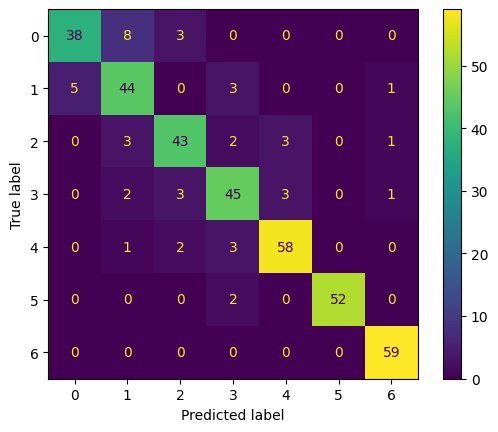

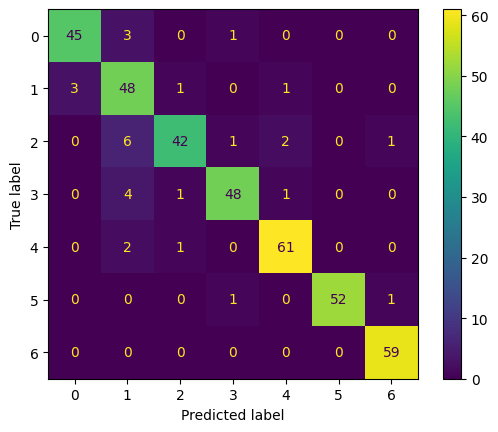

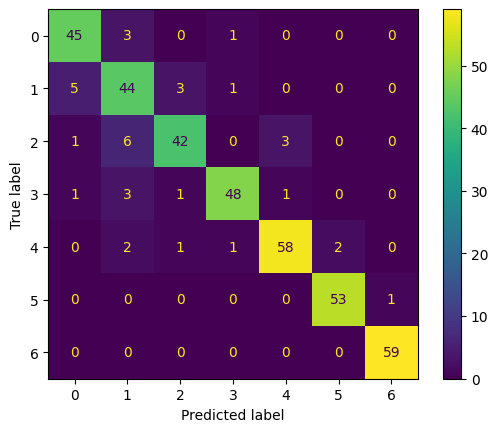

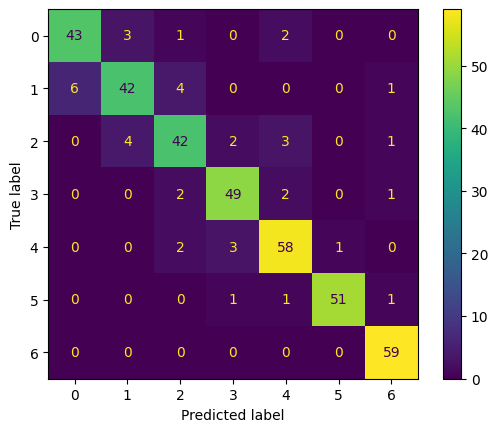

Metrics for SVM
          accuracy precision    recall  f1-score
0     8.805195e-01  0.883721   0.77551  0.826087
1     8.805195e-01  0.758621  0.830189  0.792793
2     8.805195e-01  0.843137  0.826923  0.834951
3     8.805195e-01  0.818182  0.833333  0.825688
4     8.805195e-01   0.90625   0.90625   0.90625
5     8.805195e-01       1.0  0.962963  0.981132
6     8.805195e-01  0.951613       1.0  0.975207
mean  8.805195e-01  0.880454  0.877266  0.878064
std   1.359740e-16   0.06679   0.06692  0.062753


Metrics for Random Forest
          accuracy precision    recall  f1-score
0     9.220779e-01    0.9375  0.918367  0.927835
1     9.220779e-01  0.761905   0.90566  0.827586
2     9.220779e-01  0.933333  0.807692  0.865979
3     9.220779e-01  0.941176  0.888889  0.914286
4     9.220779e-01  0.938462  0.953125  0.945736
5     9.220779e-01       1.0  0.962963  0.981132
6     9.220779e-01  0.967213       1.0  0.983333
mean  9.220779e-01  0.925408  0.920038  0.921154
std   1.359740e-16  0.062

In [79]:
print_synoptic_metrics(df)

### The original dataset

#### Searching the best hyperparameter configurations

In [80]:
df = compose(impute_data, normalize_data, convert_to_numbers, preprocess, get_data)(FILE)

In [81]:
get_best_svm(df)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.639 total time=   0.2s
[CV 2/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.711 total time=   0.2s
[CV 4/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.685 total time=   0.2s
[CV 3/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.706 total time=   0.2s
[CV 5/5] END ....C=0.01, gamma=1, kernel=linear;, score=0.734 total time=   0.2s
[CV 1/5] END ..C=0.01, gamma=0.1, kernel=linear;, score=0.639 total time=   0.1s
[CV 2/5] END ..C=0.01, gamma=0.1, kernel=linear;, score=0.711 total time=   0.2s
[CV 4/5] END ..C=0.01, gamma=0.1, kernel=linear;, score=0.685 total time=   0.2s
[CV 5/5] END ..C=0.01, gamma=0.1, kernel=linear;, score=0.734 total time=   0.2s
[CV 3/5] END ..C=0.01, gamma=0.1, kernel=linear;, score=0.706 total time=   0.2s
[CV 2/5] END ...C=0.01, gamma=1, kernel=sigmoid;, score=0.167 total time=   0.4s
[CV 3/5] END ...C=0.01, gamma=1, kernel=sigmoid

SVC(C=10, gamma=0.1)

In [82]:
get_best_rf(df)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END max_depth=6, max_samples=0.3, n_estimators=50;, score=0.639 total time=   0.1s
[CV 2/5] END max_depth=6, max_samples=0.3, n_estimators=50;, score=0.875 total time=   0.1s
[CV 3/5] END max_depth=6, max_samples=0.3, n_estimators=50;, score=0.854 total time=   0.1s
[CV 4/5] END max_depth=6, max_samples=0.3, n_estimators=50;, score=0.862 total time=   0.1s
[CV 5/5] END max_depth=6, max_samples=0.3, n_estimators=50;, score=0.870 total time=   0.1s
[CV 1/5] END max_depth=6, max_samples=0.3, n_estimators=100;, score=0.655 total time=   0.3s
[CV 2/5] END max_depth=6, max_samples=0.3, n_estimators=100;, score=0.906 total time=   0.3s
[CV 3/5] END max_depth=6, max_samples=0.3, n_estimators=100;, score=0.867 total time=   0.3s
[CV 4/5] END max_depth=6, max_samples=0.3, n_estimators=100;, score=0.878 total time=   0.3s
[CV 1/5] END max_depth=6, max_samples=0.5, n_estimators=50;, score=0.623 total time=   0.2s
[CV 5/5] END 

RandomForestClassifier(max_depth=14, max_samples=0.9)

In [83]:
get_best_et(df)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimators=50;, score=0.616 total time=   0.2s
[CV 2/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimators=50;, score=0.792 total time=   0.2s
[CV 4/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimators=50;, score=0.815 total time=   0.2s
[CV 3/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimators=50;, score=0.737 total time=   0.2s
[CV 5/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimators=50;, score=0.799 total time=   0.2s
[CV 1/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimators=100;, score=0.590 total time=   0.4s
[CV 2/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimators=100;, score=0.792 total time=   0.4s
[CV 3/5] END bootstrap=True, max_depth=6, max_samples=0.3, n_estimators=100;, score=0.784 total time=   0.4s
[CV 1/5] END bootstrap=True, max_depth=6, max_samples=0.5, n_estimator

ExtraTreesClassifier(bootstrap=True, max_depth=14, max_samples=0.8,
                     n_estimators=500)

In [84]:
get_best_xgb(df)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[CV 2/5] END learning_rate=0.01, n_estimators=50;, score=0.875 total time=   0.9s[CV 1/5] END learning_rate=0.01, n_estimators=50;, score=0.696 total time=   0.9s

[CV 5/5] END learning_rate=0.01, n_estimators=50;, score=0.878 total time=   0.9s
[CV 4/5] END learning_rate=0.01, n_estimators=50;, score=0.865 total time=   0.9s
[CV 3/5] END learning_rate=0.01, n_estimators=50;, score=0.896 total time=   0.9s
[CV 5/5] END learning_rate=0.01, n_estimators=100;, score=0.885 total time=   1.7s
[CV 1/5] END learning_rate=0.1, n_estimators=50;, score=0.727 total time=   0.8s
[CV 2/5] END learning_rate=0.01, n_estimators=100;, score=0.891 total time=   1.7s
[CV 1/5] END learning_rate=0.01, n_estimators=100;, score=0.694 total time=   1.7s
[CV 4/5] END learning_rate=0.01, n_estimators=100;, score=0.893 total time=   1.7s
[CV 3/5] END learning_rate=0.01, n_estimators=100;, score=0.898 total time=   1.7s
[CV 2/5] END learning_rate=0.1, n_estimators=50;, score=0.930 total time=   0.8s
[CV 3/5] END 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

#### Training the classifiers with the best hyperparameters and reporting the results

In [85]:
print_detailed_metrics(df)

Metrics for SVM
              precision    recall  f1-score     support
0              0.909091  0.816327  0.860215   49.000000
1              0.750000  0.849057  0.796460   53.000000
2              0.888889  0.769231  0.824742   52.000000
3              0.854545  0.870370  0.862385   54.000000
4              0.865672  0.906250  0.885496   64.000000
5              1.000000  0.962963  0.981132   54.000000
6              0.951613  1.000000  0.975207   59.000000
accuracy       0.885714  0.885714  0.885714    0.885714
macro avg      0.888544  0.882028  0.883663  385.000000
weighted avg   0.888860  0.885714  0.885736  385.000000


Metrics for Random Forest
              precision    recall  f1-score     support
0              0.918367  0.918367  0.918367   49.000000
1              0.770492  0.886792  0.824561   53.000000
2              0.933333  0.807692  0.865979   52.000000
3              0.942308  0.907407  0.924528   54.000000
4              0.936508  0.921875  0.929134   64.000000
5   

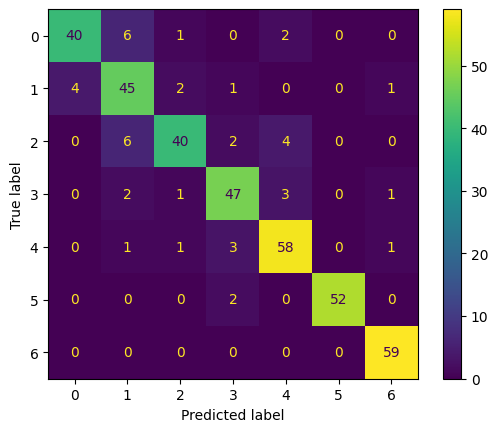

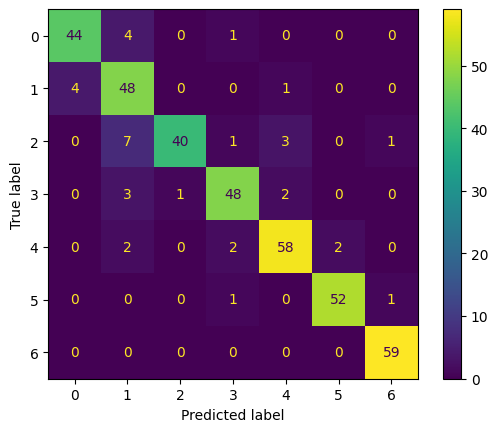

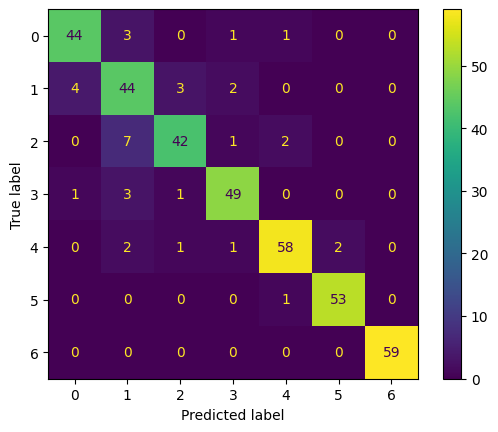

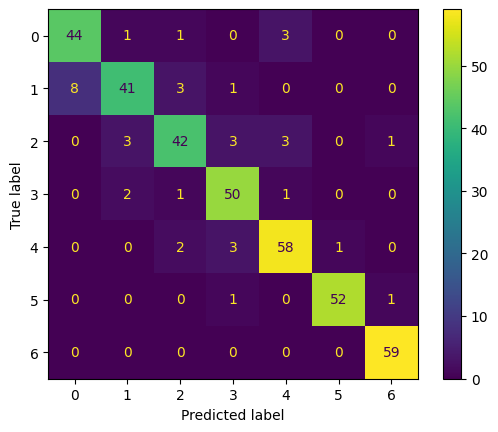

Metrics for SVM
      accuracy precision    recall  f1-score
0     0.885714  0.909091  0.816327  0.860215
1     0.885714      0.75  0.849057   0.79646
2     0.885714  0.888889  0.769231  0.824742
3     0.885714  0.854545   0.87037  0.862385
4     0.885714  0.865672   0.90625  0.885496
5     0.885714       1.0  0.962963  0.981132
6     0.885714  0.951613       1.0  0.975207
mean  0.885714  0.888293  0.882765  0.884075
std   0.000000  0.064725  0.066114  0.057705


Metrics for Random Forest
      accuracy precision    recall  f1-score
0     0.906494  0.916667  0.897959  0.907216
1     0.906494      0.75   0.90566  0.820513
2     0.906494   0.97561  0.769231  0.860215
3     0.906494   0.90566  0.888889  0.897196
4     0.906494   0.90625   0.90625   0.90625
5     0.906494  0.962963  0.962963  0.962963
6     0.906494  0.967213       1.0  0.983333
mean  0.906494  0.911556  0.904836  0.905641
std   0.000000  0.063298  0.058816  0.045593


Metrics for ExtraTrees
      accuracy precision    rec

In [86]:
print_synoptic_metrics(df)